In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_trader import EMA_trader

In [2]:
history = pd.read_csv('./binance_DOGEBTC_1m.csv') # dogecoin data
# history = history.iloc[0:80000]
prices = history['open'].tolist()

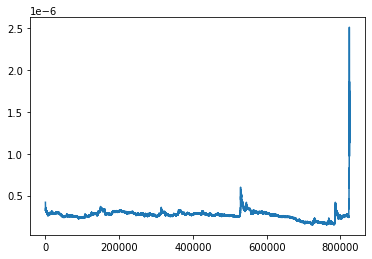

In [3]:
plt.plot(prices)

In [4]:
tr = EMA_trader()

optimization_period = 5000

# quantities of Doge/BTC
# we want to have good params before starting to trade, so execute
# this in a blocking fashion
t0 = time.perf_counter()
parameters = tr.optimize_multiprocess(prices[:optimization_period])
tr.set_params(*parameters)
print(time.perf_counter() - t0)

doge, BTC = 100, 0
bt = np.zeros_like(prices[optimization_period:])
dg = np.zeros_like(prices[optimization_period:])

prev_price = prices[optimization_period - 1]

num_buys = num_sells = 0

for i, price in enumerate(prices[optimization_period:], optimization_period):
    time.sleep(.001)  # simulate price flow speed, which is quite slow (1 price per second)
                      # if we don't do this, optimization pools back up and everything slows down tremendously
                      # 
    percent_change = (price - prev_price) / prev_price
    doge *= 1 + percent_change

    action = tr.action(price)
    if action == tr.OrderSide.BUY:  # buy
        if BTC > 0: 
            doge += .999 * BTC
            BTC = 0
            num_buys += 1
    elif action == tr.OrderSide.SELL:  # sell
        if doge > 0:
            BTC += 0.999 * doge
            doge = 0
            num_sells += 1

    if BTC + doge < 1e-9:
        print('Bust')
        break

    bt[i-optimization_period] = BTC
    dg[i-optimization_period] = doge
    prev_price = price

    # why do this in 2 steps? because we could potentially throw the
    # call to `tr.optimize` into its own thread, and update tr once it is done.
    if (i-2) % optimization_period == 0:
        t0 = time.perf_counter()
        cb = tr.optimize_multiprocess_async(prices[i-optimization_period:i])

        print(f"{100 * (i - optimization_period) / (len(prices) - optimization_period):.2f}%: Optimized in {time.perf_counter() - t0:.2f} s")
        print(f"BTC: {BTC}\tDOGE: {doge}\tNUM BUYS: {num_buys}\tNUM SELLS: {num_sells}")

New Params: 0.0 9 0.0 0
4.527592095999999
0.00%: Optimized in 0.00 s
BTC: 0	DOGE: 103.57142857142856	NUM BUYS: 0	NUM SELLS: 0
New Params: 0.0 9 0.0 0
0.61%: Optimized in 0.00 s
BTC: 0	DOGE: 100.0	NUM BUYS: 0	NUM SELLS: 0
New Params: 0.1 9 0.1 0
1.22%: Optimized in 0.00 s
BTC: 103.46785714285734	DOGE: 0.0	NUM BUYS: 0	NUM SELLS: 1
New Params: 0.1 9 0.1 0
1.83%: Optimized in 0.00 s
BTC: 103.46785714285734	DOGE: 0.0	NUM BUYS: 0	NUM SELLS: 1
New Params: 0.2 1 0.2 0
2.44%: Optimized in 0.00 s
BTC: 103.46785714285734	DOGE: 0.0	NUM BUYS: 0	NUM SELLS: 1
New Params: 0.1 9 0.1 0
3.05%: Optimized in 0.00 s
BTC: 103.46785714285734	DOGE: 0.0	NUM BUYS: 0	NUM SELLS: 1
New Params: 0.2 1 0.2 0
3.66%: Optimized in 0.00 s
BTC: 103.46785714285734	DOGE: 0.0	NUM BUYS: 0	NUM SELLS: 1
New Params: 0.1 9 0.1 0
4.27%: Optimized in 0.00 s
BTC: 0	DOGE: 103.36438928571448	NUM BUYS: 1	NUM SELLS: 1
New Params: 0.0 9 0.0 0
4.88%: Optimized in 0.00 s
BTC: 0	DOGE: 99.53607857142869	NUM BUYS: 1	NUM SELLS: 1
New Params: 0.

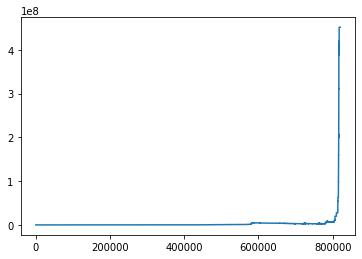

In [5]:
plt.plot(bt + dg)